In [44]:
###Libraries (not in function files)
from sklearn.model_selection import train_test_split

In [45]:
from project_dataload import *
from project_gaussian import *
from Fingerprints import *
from PCA_decomposition import *
from GP import GP

import matplotlib.pyplot as plt
from dscribe.descriptors import CoulombMatrix
from dscribe.descriptors import SineMatrix
from dscribe.descriptors import EwaldSumMatrix
from dscribe.descriptors import SOAP


In [46]:
### rmse
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [47]:
###Data load and check

data_dir="./project_data/"
train, test = data_load(data_dir)

print('Check train data')
check_data(train)
print('Check test data')
check_data(test)
summary = summarize_1(train, test)
print('Max number of atoms',summary['max_number_of_atoms'])


Check train data
Train data shape: (8000, 4)
     id        formula                                              atoms  \
0  5154         Zr2BO2  (Atom('Zr', [1.6878604657, 0.892285133, 8.1345...   
1   984          Ni2S6  (Atom('Ni', [1.1571403137, 0.934725185, 12.234...   
2  1634  Cd4K2Cl6O6Te2  (Atom('Cd', [2.7840261751, 5.6922402759, 26.71...   
3  1872      Hf4H2N3O2  (Atom('Hf', [0.0, 1.8677827772, 12.2421466347]...   
4  2977         Sc2Te2  (Atom('Te', [0.0003850118, 0.0002469812, 7.461...   

      hform  
0 -2.037877  
1 -0.091020  
2 -1.109751  
3 -1.609142  
4 -0.854593  
Check test data
Train data shape: (4000, 3)
      id     formula                                              atoms
0   8538    HfZrSTe2  (Atom('S', [-1.0327079693, 4.2080182974, 22.81...
1   9052    Nb2P2Te6  (Atom('Nb', [0.3517632032, -0.2042419274, 9.20...
2  10503  Au2InI2Se2  (Atom('Se', [0.2238411856, 0.8131388722, 26.83...
3    611   AuTlO6Sb2  (Atom('Au', [0.0002076097, -0.0001198635, 16.6...
4   

In [48]:
### Implement fingerprint
max_num_atoms = summary['max_number_of_atoms']
cmats = Coulombmatrices(train, max_num_atoms)
y_vals = train['hform']
print('Shape of cmats', cmats.shape)

0
1000
2000
3000
4000
5000
6000
7000
Shape of cmats (8000, 400)


In [55]:
species = summary['species']
r_cut = 5
n_max = 6
l_max = 4

soap = SOAP(
    species=species,
    r_cut = r_cut,
    n_max = n_max,
    l_max = l_max)

soap.get_number_of_features()

346890

In [65]:
### fingerprints #2

def soapmatrices(train, species, r_cut, n_max, l_max):
    soap = SOAP(
    species=species,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    )  

    #Number of features in soap object
    num_feat = soap.get_number_of_features()
    
    soaps = np.zeros((len(train),num_feat))
    for i,atoms in enumerate(train.atoms):
        if i%1000 == 0:
            print(i)
        soaps[i,:] = soap.create(atoms)
    
    return soaps

species = summary['species']
r_cut = 2
n_max = 1
l_max = 1

soapmatrices(train, species, r_cut, n_max, l_max)

MemoryError: Unable to allocate 238. MiB for an array with shape (8000, 3906) and data type float64

In [ ]:
# Set target and feature vector 
X = pd.DataFrame(data = soaps, index=train.id)
y = pd.DataFrame(train['hform'].values, index = train.id)
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (8000, 400)
y: (8000, 1)


In [27]:
# Split training data into a training set and a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)
y_test_values = y_test.values  # Extract values as a NumPy array
y_train_values = y_train.values  # Extract values as a NumPy array

Shape of split data:  (6400, 400) (1600, 400) (6400, 1) (1600, 1)


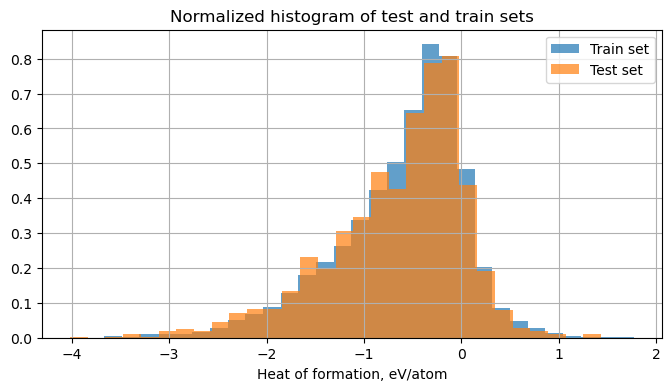

In [28]:
### Check split data
print('Shape of split data: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.figure(figsize = (8, 4))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.grid()
plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()


In [29]:
# PC Decomposition

n_PC = 135

X_train_pca, X_test_pca = PCA_decomposition(X_train, X_test, n_PC)

In [30]:
# Gaussian process
simpleGP = GP(X_train_pca, y_train_values, sigma = 0.003)

In [37]:
# Train and predict
k = 10
l= 0.04
simpleGP.train_GP(l, k)
predictions = np.array([simpleGP.predict(fingerprint) for fingerprint in X_test_pca])


With l = 0.04 RMSE = 0.6919968403043593


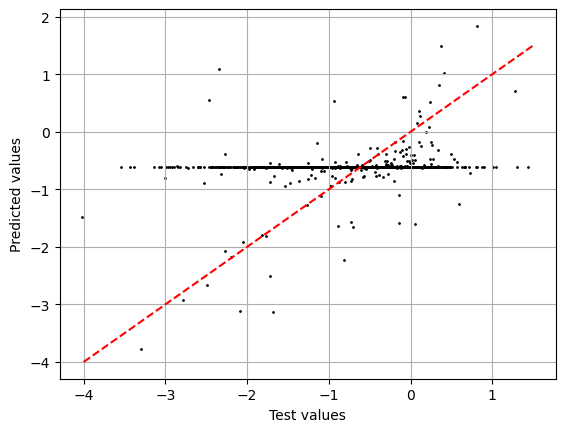

In [38]:
print(f"With l = {l} RMSE = {rmse(y_test_values, predictions)}")

plt.figure()
plt.scatter(y_test_values, predictions, s = 1,color='black')
plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.grid()
xg = np.linspace(-4,1.5, 2)
plt.plot(xg,xg, color = 'red', linestyle = 'dashed')